In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import datetime as dt
import nltk
#nltk.download('omw-1.4')
from pattern.en import sentiment
import re
import scipy
import statsmodels.stats.multitest as multiple


_Please note that as we merged our 4 jupyter notebooks for the milestone 2, we created multiple copies of the dataset in order to make it simpler to execute and understand._

## Load, filter and transform the data

In [2]:
# load the data

data_folder = './MovieSummaries/'
plots = pd.read_csv(data_folder+'plot_summaries.txt', sep='	', header=None, names=["wiki_id", "summary"])
movie_meta = pd.read_csv(data_folder+'movie.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "movie_name", "release_date", "revenue", "runtime", "languages", "countries", "genres"])
char_meta = pd.read_csv(data_folder+'character.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "release_date", "character_name", "birth", "gender", "height", "ethnicity", "actor_name", "actor_age", "character_actor_map", "character_id", "actor_id"])

# we dont load clusters of latent personas because we are not gonna use them

#tvtropes_clusters = pd.read_csv(data_folder+'tvtropes.clusters.txt')
#name_clusters = pd.read_csv(data_folder+'name.clusters.txt') 


In [3]:
summaries = plots.copy() # this is for the sentiment analysis part

In [4]:
# merge plot summaries database with movie meta database

merged = plots.merge(movie_meta, on="wiki_id", how="right")
merged.head()


,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,"Set in the second half of the 22nd century, th...",/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,NaN,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,NaN,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,A series of murders of rich young women throug...,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,"Eva, an upper class housewife, becomes frustra...",/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
# change dicts into values

merged["languages"] = merged.apply(lambda x: list(eval(x["languages"]).values()), axis=1)
merged["countries"] = merged.apply(lambda x: list(eval(x["countries"]).values()), axis=1)
merged["genres"] = merged.apply(lambda x: list(eval(x["genres"]).values()), axis=1)


In [6]:
#fixing outlier and converting to datetime

merged.summary = merged.summary.fillna('')
merged.loc[merged['wiki_id']== 29666067, 'release_date'] = dt.datetime(2010, 12, 2)
dates = pd.to_datetime(merged['release_date'])
merged['release_date'] = dates


#for sentiment analysis
df_sentiment = merged.copy()
#for merging with additional datasets
df_additional = merged.copy()
df_additional = df_additional[df_additional['release_date'].notna()]  
#for plotting even more 
df = merged.copy()

In [7]:
#df = df[df["release_date"].dt.year < 1915]
long_movies = merged[merged.genres.apply(lambda x : not "Short Film" in x)]
long_movies_us = merged[merged.countries.apply(lambda x : "United States of America" in x)]
long_movies_us

,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,"Set in the second half of the 22nd century, th...",/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
5,13696889,,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
7,10408933,,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
10,175026,,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]"
...,...,...,...,...,...,...,...,...,...,...
81725,1918494,Havoc is wrought on the inhabitants of a small...,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]"
81726,664006,Jennifer Haines is an up-and-coming Chicago a...,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,[],[United States of America],"[Thriller, Erotic thriller, Psychological thri..."
81727,24209227,,/m/07k5mlk,"The Time, the Place and the Girl",1946-01-01,NaN,105.0,[English Language],[United States of America],"[Comedy film, Romance Film, Musical]"
81736,35228177,Two former National Oceanic Atmospheric Admini...,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama]


## Themes and genres evolution analysis


Text(0.5, 1.0, 'Proportion of War Films by year')

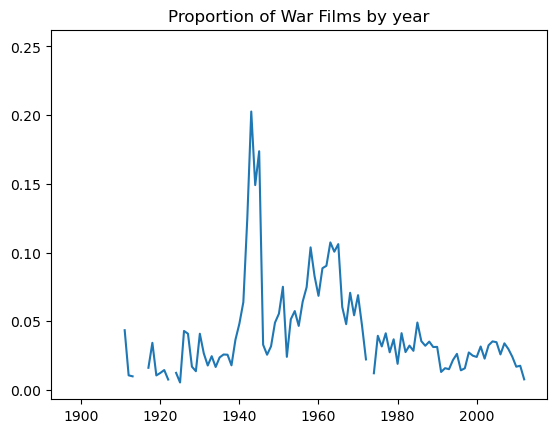

In [8]:
# What is the proportion of war films over the years?

merged_crop = long_movies_us
num_of_movies_by_year = merged_crop.groupby(merged_crop.release_date.dt.year)['wiki_id'].count()
war_movies_genre = merged_crop[merged_crop.genres.apply(lambda x :'War film' in x)]
war_movies_by_year_genre = war_movies_genre.groupby(war_movies_genre.release_date.dt.year)['wiki_id'].count()
war_movies_by_year_genre = war_movies_by_year_genre/num_of_movies_by_year
plt.plot(war_movies_by_year_genre)
plt.title("Proportion of War Films by year")


In [9]:
# return 1 when a set of words is used in the plot summary

def summary_contains_words(summary, words):
    if str(summary) == "nan":
        return 0
    for word in words:
        strings = summary.lower().split(" ")
        if word in summary.lower().split(" "):
            return 1
    return 0
   

Text(0.5, 1.0, 'Proportion of War Films by year')

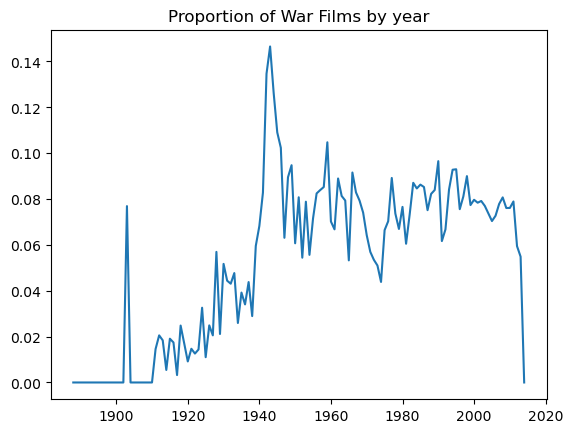

In [10]:
# How often do the words related to war show up in plot summaries by year ?

war_related = ["war", "warfare", "battle", "military", "soldier", "jihad", "crusade"]
merged = merged[merged["release_date"].dt.year < 2015]
merged["war_related"] = merged.apply(lambda x: summary_contains_words(x["summary"], war_related), axis=1)
num_of_movies_by_year = merged.groupby(merged.release_date.dt.year)['wiki_id'].count()
war_movies = merged[merged.war_related.apply(lambda x : x == 1)]
war_movies_by_year = war_movies.groupby(war_movies.release_date.dt.year)['wiki_id'].count()
war_movies_by_year_proportion = war_movies_by_year/num_of_movies_by_year
war_movies_proportion_without_nan = war_movies_by_year_proportion.fillna(0)
plt.plot(war_movies_proportion_without_nan)
plt.title("Proportion of War Films by year")

Text(0.5, 1.0, 'Proportion of terrorism related Films by year')

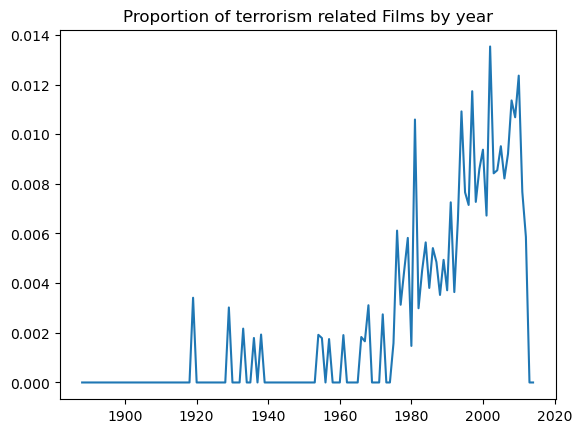

In [11]:
# How often do the words related to war show up in plot summaries by year ?

terror_related = ["terrorism", "terrorist"]
merged["war_related"] = merged.apply(lambda x: summary_contains_words(x["summary"], terror_related), axis=1)
num_of_movies_by_year = merged.groupby(merged.release_date.dt.year)['wiki_id'].count()
war_movies = merged[merged.war_related.apply(lambda x : x == 1)]
war_movies_by_year = war_movies.groupby(war_movies.release_date.dt.year)['wiki_id'].count()
war_movies_by_year_proportion = war_movies_by_year/num_of_movies_by_year
war_movies_proportion_without_nan = war_movies_by_year_proportion.fillna(0)
plt.plot(war_movies_proportion_without_nan)
plt.title("Proportion of terrorism related Films by year")

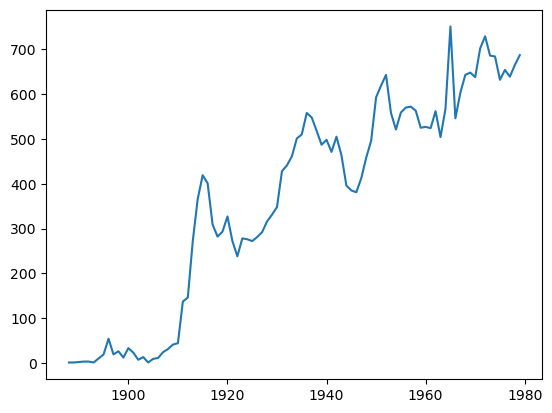

In [12]:
merged = merged[merged["release_date"].dt.year < 1980]
number_of_movies = merged.groupby(merged.release_date.dt.year)['wiki_id'].count()
plt.plot(number_of_movies)

In [13]:
merged["revenue"].dropna()

7          3600000.0
17       102272727.0
36          932000.0
85         3500000.0
88         3600000.0
            ...     
81476      5400000.0
81518      2032486.0
81583       444334.0
81589      4000000.0
81677       683131.0
Name: revenue, Length: 1622, dtype: float64

In [14]:
movie_meta.sort_values(by="revenue", ascending=False)
movie_meta

,wiki_id,freebase_id,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [15]:
m1 = movie_meta.dropna(subset=["release_date"])
m1.sort_values(by="release_date", ascending=False)


,wiki_id,freebase_id,movie_name,release_date,revenue,runtime,languages,countries,genres
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016-06-08,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}"
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,NaN,{},{},{}
64862,3139382,/m/08tyfg,Battle Angel,2016,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
53855,32416903,/m/0gys9tc,Total Dhamaal,2015,NaN,138.00,"{""/m/03k50"": ""Hindi Language""}",{},"{""/m/05p553"": ""Comedy film""}"
8307,24179103,/m/0jwx0kc,"I, Robot 2",2015,NaN,NaN,{},{},"{""/m/06n90"": ""Science Fiction""}"
...,...,...,...,...,...,...,...,...,...
60249,22770416,/m/0gj9h_4,London's Trafalgar Square,1890,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
53907,6431996,/m/0g53t3,"Monkeyshines, No. 1",1890,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}"
38764,12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",1889,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
57963,1082508,/m/044ggd,Roundhay Garden Scene,1888,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."


In [16]:
# helpers for plotting

def plot_proportion(proportion,title):
    proportion.plot.bar(rot=45, figsize=(10, 6))
    plt.locator_params(nbins=20)
    plt.title(title)
    return proportion

def create_proportion_by_year(number_of_films):
    tot_by_year = df.groupby(df.release_date.dt.year)['wiki_id'].count()
    number_of_films_by_year = number_of_films.groupby(number_of_films.release_date.dt.year)['wiki_id'].count()
    number_of_films_by_year = number_of_films_by_year/tot_by_year
    return number_of_films_by_year.apply(lambda x: 0 if np.isnan(x) else x)

def proportion_of_movies_with_war_in_summary(df, title):
    pd.options.mode.chained_assignment = None
    war_movies = df[df.summary.str.lower().str.contains('war')]
    proportion_summary = create_proportion_by_year(war_movies)
    return plot_proportion(proportion_summary, title)

def proportion_of_nazis_in_summary(df, title):
    pd.options.mode.chained_assignment = None
    movies_with_nazis = df[df.summary.str.lower().str.contains('nazi')]
    nazis_by_year = create_proportion_by_year(movies_with_nazis)
    return plot_proportion(nazis_by_year, title)

def proportion_of_war_movies(df, title):
    war_movies_genre = df[df.genres.apply(lambda x :'War film' in x)]
    proportion_genre = create_proportion_by_year(war_movies_genre)
    return plot_proportion(proportion_genre, title)

def proportion_of_anti_war_movies(df, title):
    anti_war_movies_genre = df[df.genres.apply(lambda x :'Anti-war' in x)]
    proportion_anti_genre = create_proportion_by_year(anti_war_movies_genre)
    return plot_proportion(proportion_anti_genre, title)

def p_value_for_diff_years(war_movies, ind, WWII_ind):
    WWII=war_movies.loc[(war_movies.index <= WWII_ind[1]) & (war_movies.index >= WWII_ind[0])]
    p_values = []
    for lower, upper in ind:
        other = war_movies.loc[(war_movies.index <= upper) & (war_movies.index >= lower)]
        stat, p_value = scipy.stats.ttest_ind(WWII, other)
        p_values.append(p_value)
    return p_values


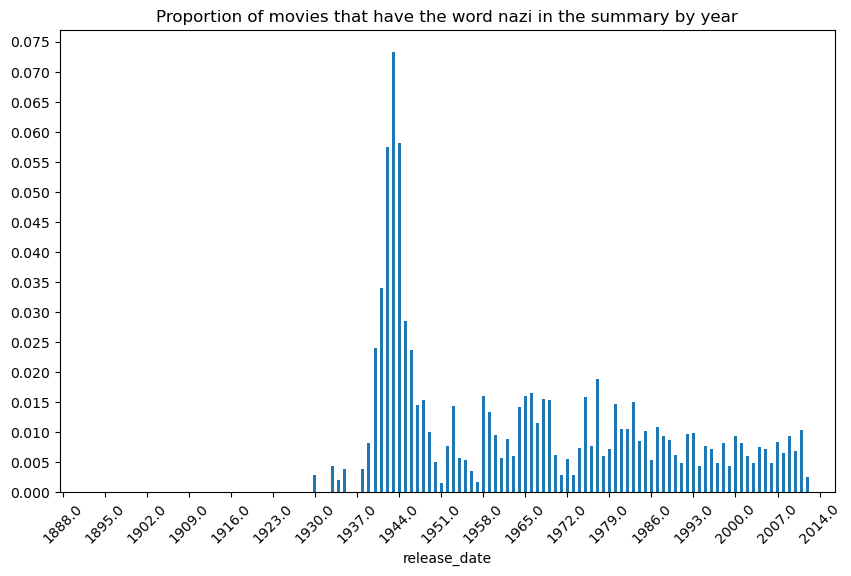

In [17]:
nazis_in_summaries=proportion_of_nazis_in_summary(df, "Proportion of movies that have the word nazi in the summary by year")

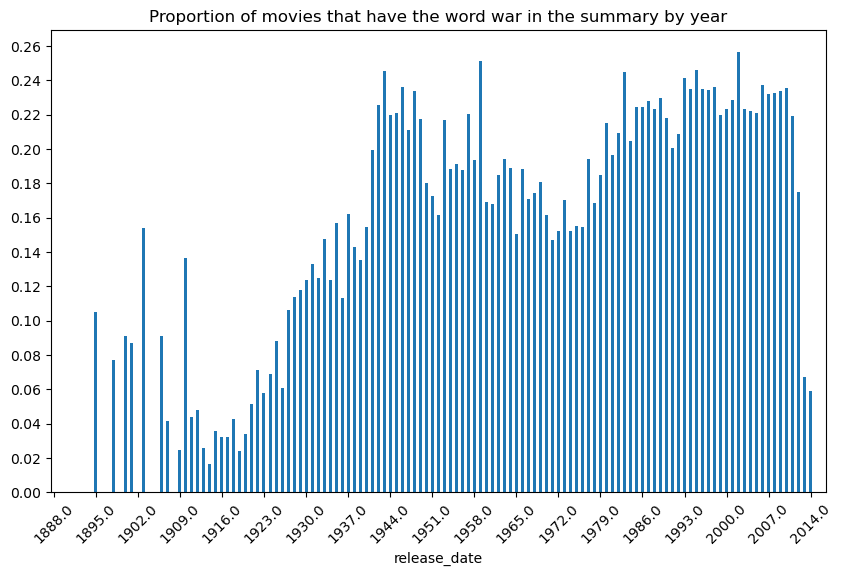

In [18]:
war_movies_by_year_summary=proportion_of_movies_with_war_in_summary(df, "Proportion of movies that have the word war in the summary by year")

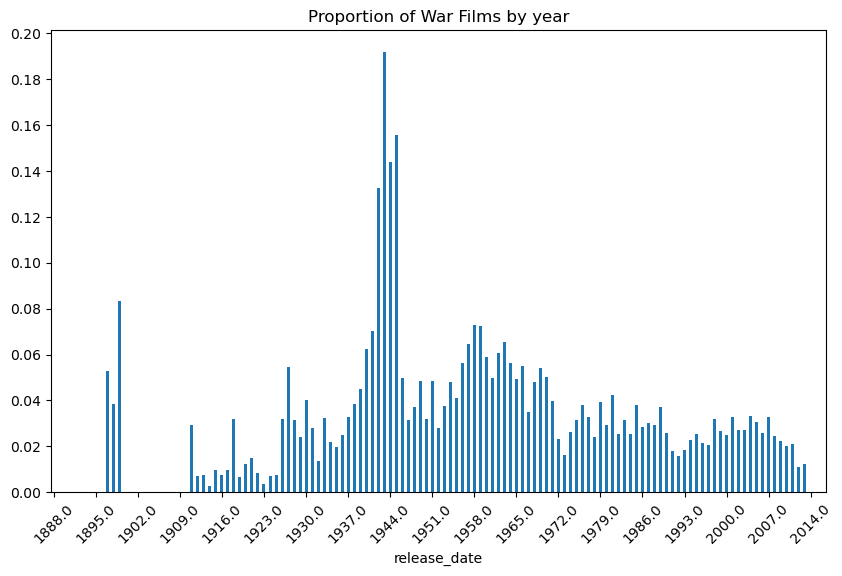

In [19]:
war_movies_by_year = proportion_of_war_movies(df, "Proportion of War Films by year")

In [44]:
#We're gonna compare the difference of movie production of movies made during 1939 and 1945 and movies made at other times
#We're gonna calulate the p-values of movies with the word 'war' in them, or movies with the word 'nazi' in them and
#finally just war movies in general

WWII_ind = (1939,1945)
a =np.arange(1918, 2000, 7)
b = np.arange(1924, 2007, 7)
indexes = list(zip(a,b))
print(indexes)
p_values_genres = p_value_for_diff_years(war_movies_by_year, indexes, WWII_ind)
p_values_summaries = p_value_for_diff_years(war_movies_by_year_summary, indexes, WWII_ind)
p_values_nazis = p_value_for_diff_years(nazis_in_summaries, indexes, WWII_ind)
multi_genres = multiple.multipletests(p_values_genres)
multi_summaries = multiple.multipletests(p_values_summaries)
multi_nazis = multiple.multipletests(p_values_nazis)


[(1918, 1924), (1925, 1931), (1932, 1938), (1939, 1945), (1946, 1952), (1953, 1959), (1960, 1966), (1967, 1973), (1974, 1980), (1981, 1987), (1988, 1994), (1995, 2001)]


/home/xavier/miniconda3/lib/python3.8/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [50]:
print("Statistical significance of movies containing the word war :")
list(zip(indexes, multi_summaries[1], multi_summaries[0]))

statistical significance of movies containing the word war :


[((1918, 1924), 1.294082930452511e-05, True),
 ((1925, 1931), 0.002208866460544339, True),
 ((1932, 1938), 0.032118214178689306, True),
 ((1939, 1945), 1.0, False),
 ((1946, 1952), 0.9949266231388167, False),
 ((1953, 1959), 0.9748151494174879, False),
 ((1960, 1966), 0.7469133110922115, False),
 ((1967, 1973), 0.3611297707686104, False),
 ((1974, 1980), 0.7469133110922115, False),
 ((1981, 1987), 0.7469133110922115, False),
 ((1988, 1994), 0.7469133110922115, False),
 ((1995, 2001), 0.4135888300292103, False)]

In [52]:
print("Statistical significance of war movies :")
list(zip(indexes, multi_genres[1], multi_genres[0]))

Statistical significance of war movies :


[((1918, 1924), 0.004987610336473554, True),
 ((1925, 1931), 0.01565773050913876, True),
 ((1932, 1938), 0.012135187281185301, True),
 ((1939, 1945), 1.0, False),
 ((1946, 1952), 0.02008493171568515, True),
 ((1953, 1959), 0.050860719323774846, False),
 ((1960, 1966), 0.050860719323774846, False),
 ((1967, 1973), 0.02008493171568515, True),
 ((1974, 1980), 0.01565773050913876, True),
 ((1981, 1987), 0.01565773050913876, True),
 ((1988, 1994), 0.011522546440642939, True),
 ((1995, 2001), 0.012135187281185301, True)]

In [53]:
print("Statistical significance of movies containing the word Nazi :")
list(zip(indexes, multi_nazis[1], multi_nazis[0]))

Statistical significance of movies containing the word Nazi :


[((1918, 1924), 0.006514978486622691, True),
 ((1925, 1931), 0.006536794305784201, True),
 ((1932, 1938), 0.008363558946680305, True),
 ((1939, 1945), 1.0, False),
 ((1946, 1952), 0.026419128662217507, True),
 ((1953, 1959), 0.026419128662217507, True),
 ((1960, 1966), 0.026419128662217507, True),
 ((1967, 1973), 0.026419128662217507, True),
 ((1974, 1980), 0.026419128662217507, True),
 ((1981, 1987), 0.026419128662217507, True),
 ((1988, 1994), 0.02114796376754459, True),
 ((1995, 2001), 0.02114796376754459, True)]

We can see that for a surface search on the summaries we can't find a statistically significant difference between the movies made during the world war two and after. But we can find a statistical difference between movies made during World War II as there are significantly more War Movies made during World War II (it isn't statistically significant if we take a threshold at 0.05, but if we take a threshold slightly higher like 0.06, then it is statistically significant. So we can say that it is mostly significant). Also the word Nazi is used significantly more in plots during the world war, which makes sense considering the context, although we might need to look if the movies are made in the US or in Germany, this might have a different meaning.

In [24]:
usDf = df[df.countries.apply(lambda x :'United States of America' in x)]
germanyDf = df[df.countries.apply(lambda x :'Germany' in x)]

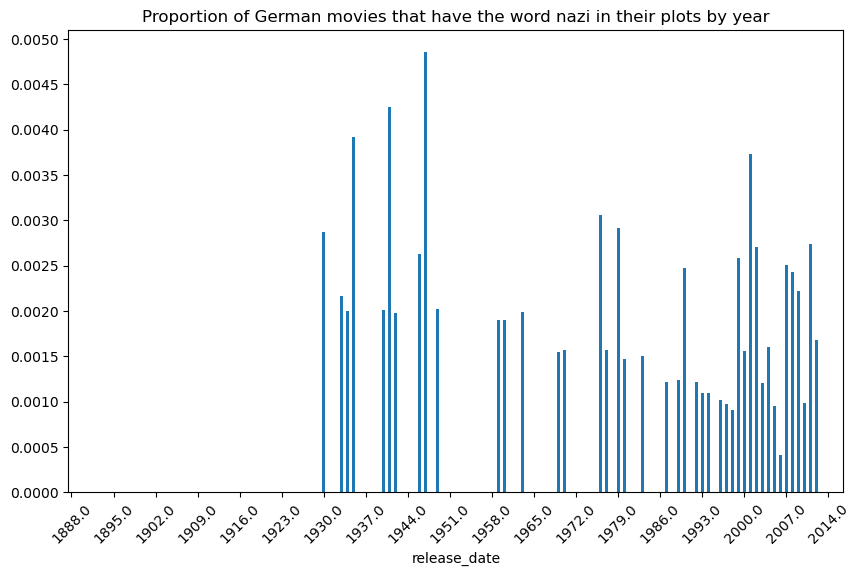

In [26]:
german_Nazi_movies = proportion_of_nazis_in_summary(germanyDf, "Proportion of German movies that have the word nazi in their plots by year")

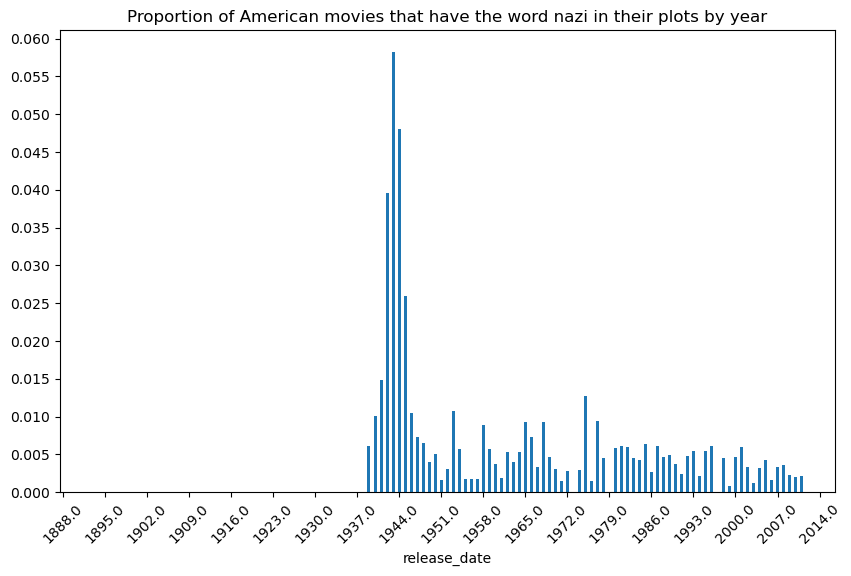

In [27]:
american_Nazi_movies = proportion_of_nazis_in_summary(usDf, "Proportion of American movies that have the word nazi in their plots by year")

In [28]:
multiple.multipletests(p_value_for_diff_years(american_Nazi_movies, indexes, WWII_ind), alpha=0.06)

/home/xavier/miniconda3/lib/python3.8/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


(array([ True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True]),
 array([0.02883675, 0.02883675, 0.02883675, 1.        , 0.05348677,
        0.05348677, 0.05348677, 0.05348677, 0.05348677, 0.05348677,
        0.05348677, 0.05348677]),
 0.005143012831822946,
 0.005)

In [29]:
multiple.multipletests(p_value_for_diff_years(german_Nazi_movies, indexes, WWII_ind), alpha=0.06)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([0.64819114, 0.9630491 , 0.99982173, 1.        , 0.99982173,
        0.92327007, 0.97321093, 0.9630491 , 0.99982173, 0.95293394,
        0.99982173, 0.99812512]),
 0.005143012831822946,
 0.005)

We can see that the difference of plots that use the word Nazi in American movies during world war II is significant, but not for movies made in Germany. This doesn't make sense considering the context of the time, but might make sens considering the bias of the data that mostly contains american movies. Although we might notice also that German movies contain in proportion way more movies with Nazis in them and that they appear in 1930 whereas in American movies they first appear in 1939. We should increase the size of German movies during and after World War II in the dataset to continue this analysis.

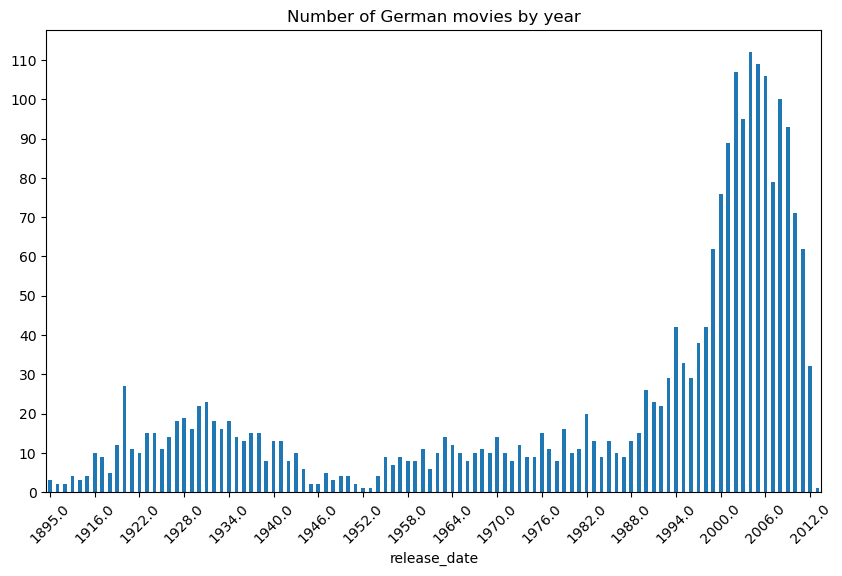

In [30]:
number_of_German_movies =plot_proportion(germanyDf.groupby(germanyDf.release_date.dt.year)['wiki_id'].count(), 'Number of German movies by year')

## Sentiment analysis


In [31]:
# data preparation for sentiment analysis

total_length = len(summaries) # number of samples
summary_with_war = summaries[summaries['summary'].str.contains('war')] # select only the data with 'war' in it
with_war_length = len(summary_with_war)
print('There is', with_war_length, 'movies with world war in the summary')
print('pourcentage = ', len(summary_with_war)/total_length * 100)


There is 14079 movies with world war in the summary
pourcentage =  33.281327565420895


In [32]:
# compute average sentiment of war movies

df_sentiment_forall = df_sentiment.copy()
print(len(df_sentiment))
df_sentiment['is_war_film'] = df_sentiment['genres'].apply(lambda x: 'War film' in x) # add a indicator of war movie or not
df_sentiment = df_sentiment[df_sentiment.is_war_film] # select only the war movies
df_sentiment['sentiment'] = df_sentiment['summary'].apply(lambda x: sentiment(x)) # apply sentiment analysis over the summaries
df_sentiment['sentiment'] = df_sentiment['sentiment'].apply(lambda x: x[0]) # select only the sentiment score
df_sentiment = df_sentiment[(df_sentiment['sentiment'] != 0)] # take data only where there is a summary
average_sentiment = df_sentiment['sentiment'].sum() / len(df_sentiment)
print("average sentiment :", average_sentiment)


81741
average sentiment : 0.02891878364859746


In [33]:
# compute average sentiment of all movies

df_sorted = df_sentiment_forall.sort_values(by=['release_date'])
df_sorted['sentiment'] = df_sorted['summary'].apply(lambda x: sentiment(x))
df_sorted['sentiment'] = df_sorted['sentiment'].apply(lambda x: x[0])
df_sorted = df_sorted[(df_sorted['sentiment'] != 0)]
# Now we have obtained all sentiment scores for all movies.

def calculate_average_sentiment(df):
    return df['sentiment'].sum() / len(df)

av_of_all_movies = calculate_average_sentiment(df_sorted)
print('the average is :', av_of_all_movies)

df_sorted.sample(5)

the average is : 0.04721542729080025


,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,countries,genres,sentiment
68744,13824842,Bugs Bunny is standing at the base of the famo...,/m/03ckdg5,Bowery Bugs,1949-06-04,NaN,NaN,[English Language],[],"[Short Film, Family Film, Comedy, Animation]",0.074217
24411,12685218,"Paul Hogan plays Lightning Jack Kane, an Austr...",/m/02x0fvc,Lightning Jack,1994-03-11,16821273.0,105.0,[English Language],"[United States of America, Australia]","[Adventure, Action/Adventure, Western, Comedy,...",0.095833
10114,2295249,Theresa is one of the twelve jurors who have t...,/m/071ngf,A Killer Among Us,1990-01-01,NaN,100.0,[],[United States of America],"[Thriller, Mystery, Detective fiction, Psychol...",0.421111
40321,26449936,Blood will tell is a sci-fi horror film set in...,/m/0bbxwc_,Blood Will Tell,2007-09-09,NaN,6.0,[English Language],[Canada],[Short Film],-0.154881
21793,10943915,"The story revolves around Elder Farrell a ""by...",/m/02qvqxs,States of Grace,2005-01-01,NaN,128.0,[English Language],[United States of America],[Drama],0.002503




The average over all movies is 0.047 (this is 1.6 times more 'happy' than the war movies)



#### Let's see the average sentiment analysis over different countries and different periods.

In [34]:
# helper functions for sentiment analysis

def get_country_movies(df, country):
    return df[df.countries.apply(lambda x : country in x)]

def create_history_span(df, begin, end):
    return df.loc[(df.release_date.dt.year < end) & (df.release_date.dt.year > begin)]

def plot_sentiment_country_span(span):
    fig, axs = plt.subplots(figsize=(25, 5))
    sentiments = span.groupby(span.release_date.dt.year)['sentiment'].mean()
    sentiments.plot(kind='bar', rot=90, ax=axs)

## Sentiment analysis plots

Average sentiment of all movies in usa : 0.04044205833529916


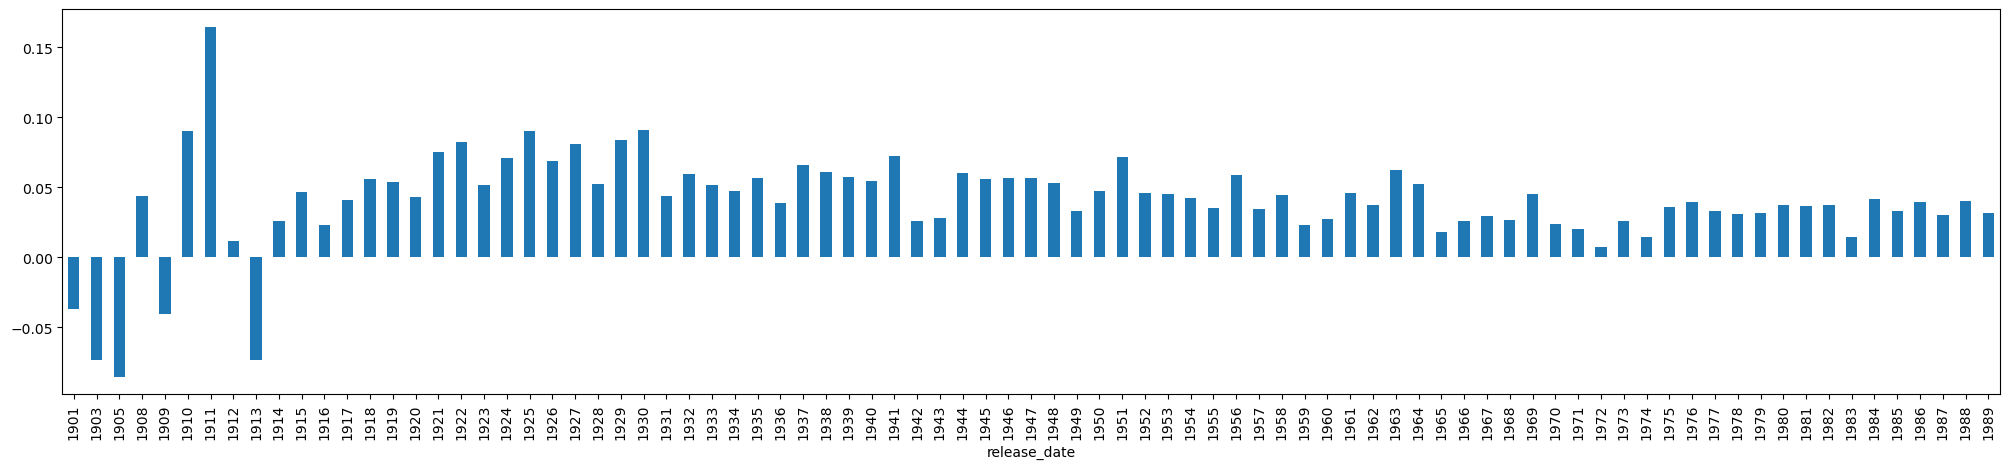

In [35]:
# plotting USA sentiment 

df_sorted_us = get_country_movies(df_sorted, 'United States of America')
print
begin = 1900
end = 1990
span_us = create_history_span(df_sorted_us, begin, end)
plot_sentiment_country_span(span_us)
print('Average sentiment of all movies in usa :', calculate_average_sentiment(df_sorted_us))

Average sentiment of all movies in germany : 0.04266313626282843


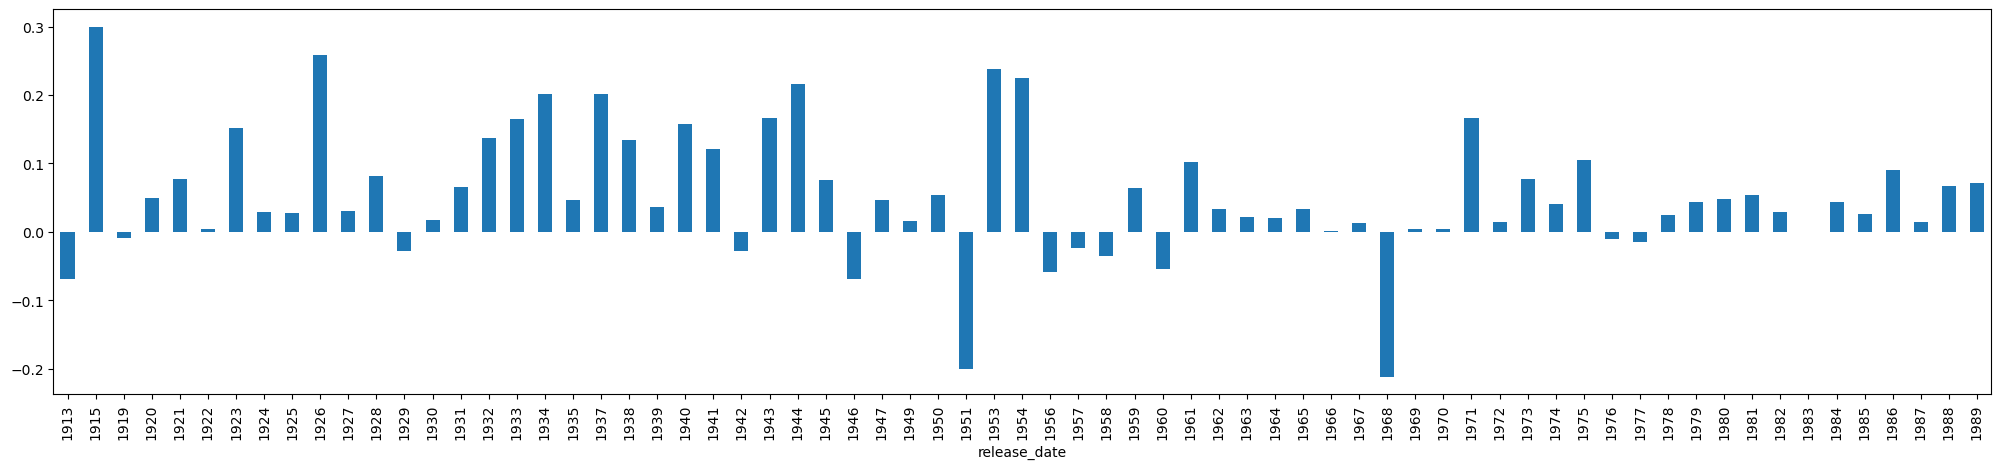

In [36]:
# plotting Germany sentiment 

df_sorted_ge = get_country_movies(df_sorted, 'Germany')

begin = 1900
end = 1990
span_ge = create_history_span(df_sorted_ge, begin, end)

plot_sentiment_country_span(span_ge)

print('Average sentiment of all movies in germany :', calculate_average_sentiment(df_sorted_ge))

Average sentiment of all movies in france : 0.05001018041703206


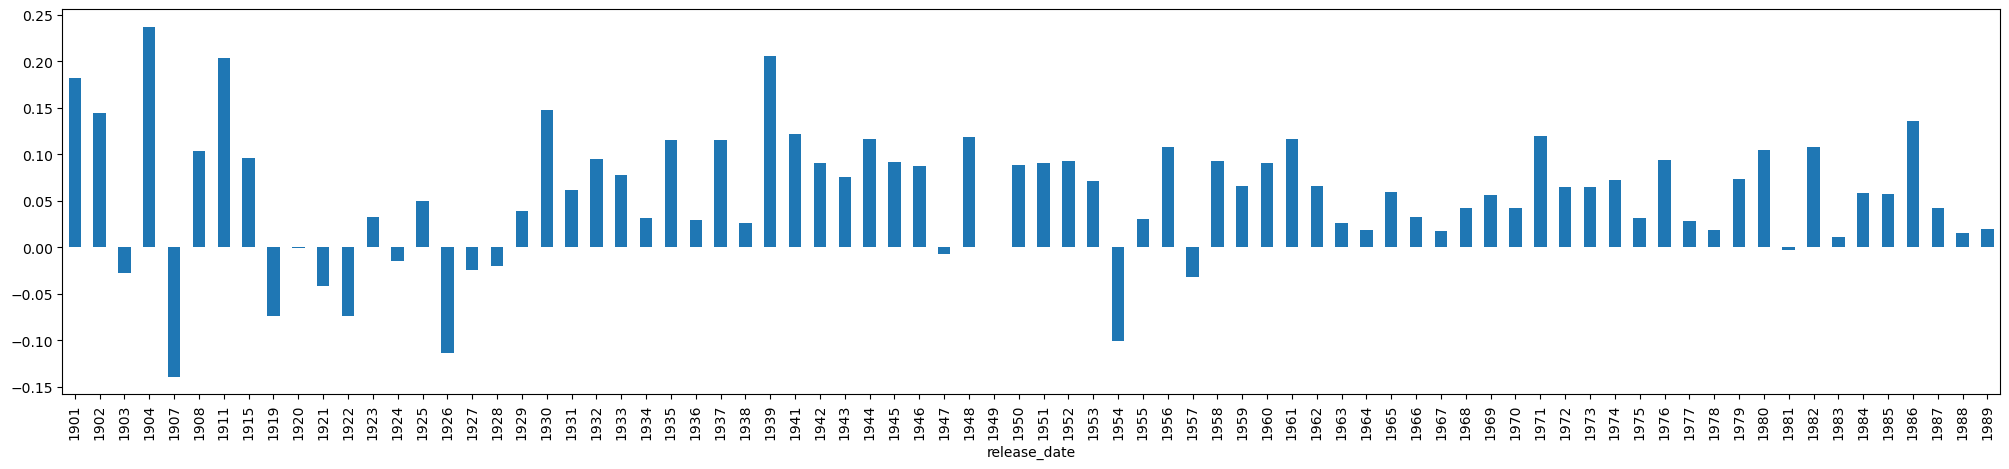

In [37]:
# plotting France sentiment 

df_sorted_fr = get_country_movies(df_sorted, 'France')

begin = 1900
end = 1990
span_fr = create_history_span(df_sorted_fr, begin, end)

plot_sentiment_country_span(span_fr)

print('Average sentiment of all movies in france :', calculate_average_sentiment(df_sorted_fr))


Average sentiment of all movies in Italy : 0.03857576341424649


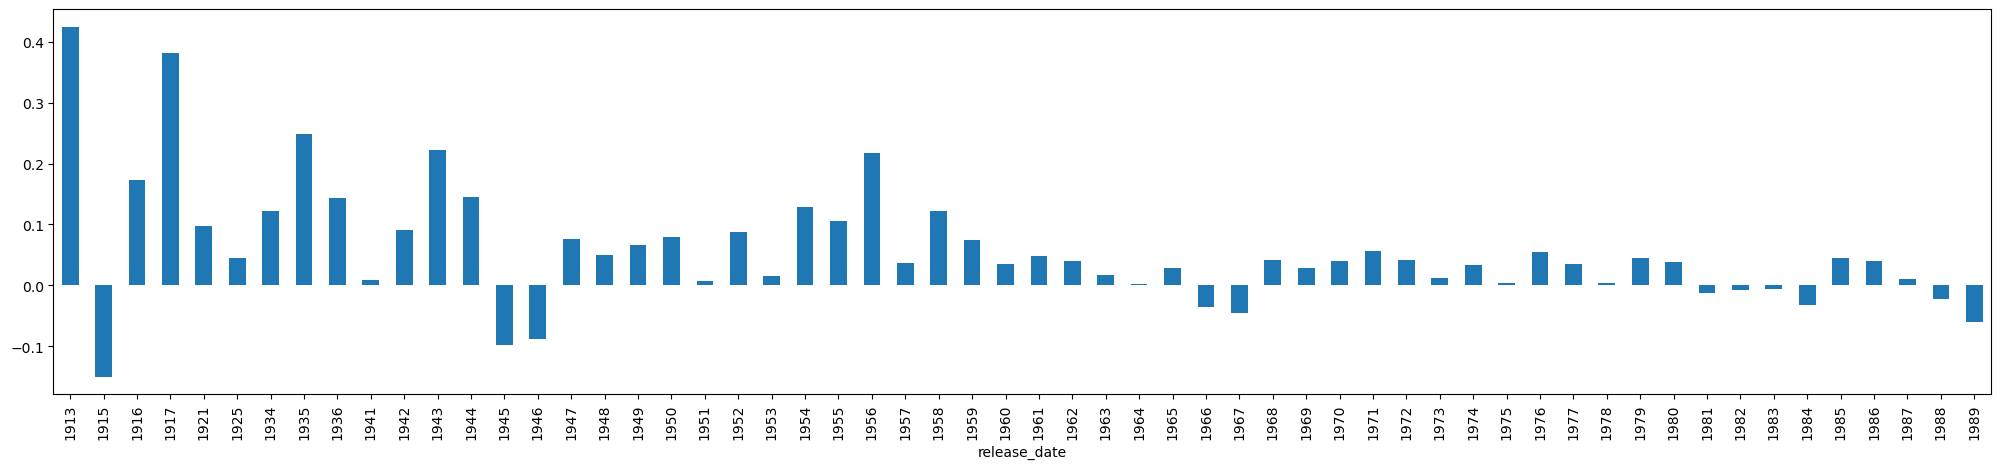

In [38]:
# plotting Italy sentiment 

df_sorted_it = get_country_movies(df_sorted, 'Italy')

begin = 1900
end = 1990
span_it = create_history_span(df_sorted_it, begin, end)

plot_sentiment_country_span(span_it)

print('Average sentiment of all movies in Italy :', calculate_average_sentiment(df_sorted_it))


## Creation of a dataset with plot summmaries 

In [39]:
# import dataset scraped from wikipedia

df_wikipedia = pd.read_json('with_plot.txt', lines=True)
df_wikipedia = df_wikipedia[['id', 'directors', 'plot']]
df_wikipedia.rename(columns={'id':'wiki_id', 'plot':'summary'}, inplace=True)
df_wikipedia = df_wikipedia[df_wikipedia['summary'].notna()] # only keep rows that have a plot summary

In [40]:
# Method for a first cleanup of the data ; this will need more work in the future

def remove_html(line):
    CLEANR = re.compile('<!--.*--') 
    CLEANR2 = re.compile('<ref.*</ref') 
    CLEANR3 = re.compile('<Ref.*</ref')
    x = re.sub(CLEANR, '', line)
    x = re.sub(CLEANR3, '', x)
    x = re.sub(CLEANR2, '', x)
    x = x.replace('\n', '') # remove newlines
    return x

# remove html references in plot summaries
df_wikipedia['summary'] = df_wikipedia['summary'].apply(lambda x : remove_html(x))
df_wikipedia.head()

,wiki_id,directors,summary
0,330,[[[Ventura Pons]]],In order to prepare herself to play a role com...
1,3217,[[[Sam Raimi]]],Having been accidentally transported to the [[...
2,3333,[[[D. W. Griffith]]],The film consists of two parts of similar leng...
3,3746,[[[Ridley Scott]]],[[Hatnote|Note: Since there are several versio...
4,3837,[[[Mel Brooks]]],"On the [[American frontier]] of 1874, a new ra..."


In [41]:
# Method that takes the wikipedia summary if the CMU database doesn't provide one

def pick_better_plot(x):
    if x.summary_x == '':
        if x['summary_y'] == '':
            return np.nan
        else:
            return x['summary_y']
    else:
        return x['summary_x']

# since we base our analysis on release dates, we remove films with no release date
df_additional = df_additional[df_additional['release_date'].notna()]  
print(len(df_additional))
    
summary_df = pd.merge(df_additional,df_wikipedia,on='wiki_id',how='left')
summary_df['summary_x'] = summary_df['summary_x'].fillna('')
summary_df['summary_y'] = summary_df['summary_y'].fillna('')

# create new column with the wikipedia summary if CMU doesn't provide one
summary_df['summary'] = summary_df.apply(lambda x : pick_better_plot(x),axis=1)

# keep only rows that have a summary
summary_df = summary_df[summary_df['summary'].notna()]
summary_df = summary_df.drop(columns=['summary_x', 'summary_y'])
summary_df.sample(10)

74839


,wiki_id,freebase_id,movie_name,release_date,revenue,runtime,languages,countries,genres,directors,summary
22282,8824700,/m/027l260,Candyman 3: Day of the Dead,1999-07-09,NaN,102.0,"[English Language, Spanish Language]",[United States of America],"[Thriller, Horror, Slasher]",[Turi Meyer],The ghostly serial killer returns once again f...
40250,33041957,/m/0h552tl,Interim,1953-01-01,NaN,26.0,[],[],[Short Film],[[[Stan Brakhage]]],"The film contains no [[dialogue]], starring on..."
60895,1130769,/m/048xyn,The Messenger: The Story of Joan of Arc,1999-10-18,66976317.0,165.0,[English Language],[France],"[Biography, World cinema, History, Biopic [fea...",[[[Luc Besson]]],{{Plot}} Joan is shown being burned at the sta...
73312,3145964,/m/08vczx,"Yours, Mine and Ours",2005-11-23,72028752.0,88.0,[English Language],[United States of America],"[Romance Film, Family Film, Comedy]",[[[Raja Gosnell]]],High school sweethearts Frank Beardsley and H...
66718,1836603,/m/05_v08,Hum Tumhare Hain Sanam,2002-05-24,NaN,174.0,[Hindi Language],[India],"[World cinema, Musical, Drama, Romantic drama,...",[[[K. S. Adhiyaman]]],Dev Narayan lives with his widowed daughter L...
66865,36324236,/m/0k3mkxv,Turning Point,2012-01-01,NaN,NaN,[English Language],[United States of America],[Drama],[[[Niyi Towolawi]]],Ade is a playboy Nigerian-American investment...
28502,3356058,/m/097fv9,Negadon: The Monster from Mars,2005-10-16,NaN,21.0,[Japanese Language],[Japan],"[Short Film, Action, Anime, Science Fiction, A...",NaN,"In the year 2025, earth sends an expedition to..."
65798,34694046,/m/0j3gvmk,Naseeb Apna Apna,1986-01-01,NaN,NaN,[Hindi Language],[India],[],[[[T. Rama Rao]]],Chandu is an innocent village girl who does no...
50936,32684003,/m/0b_l6w0,The Girls,1968-01-01,NaN,100.0,[Swedish Language],[Sweden],"[Drama, Comedy, World cinema]",[[[Mai Zetterling]]],"Liz, Marianne, and Gunilla are three actresses..."
44011,31354586,/m/04j30jf,The Vanishing American,1925-01-01,NaN,103.0,"[Silent film, English Language]",[United States of America],"[Action/Adventure, Silent film, Western, Drama...",[[[George B. Seitz]]],"The film opens long ago in Monument Valley, af..."


In [42]:
old_shape = df_additional[df_additional["summary"] != ''].shape[0]
new_shape = summary_df.shape[0]
print("Adding the Wikipedia dataset increased the number of summaries from " + str(old_shape) + " to " + str(new_shape) +".")
print("This is an increase of " + str(np.round(new_shape/old_shape * 100)) + "%.")

Adding the Wikipedia dataset increased the number of summaries from 39586 to 52136.
This is an increase of 132.0%.
